## **Import Libraries**

In [4]:
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
import pylab
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import PIL

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## **Preparing Dataset for task 3**

**Data Preprocessing:**

In [3]:
# specify paths 
label_file = '..\CelebA\Anno\list_attr_celeba.txt'
img_dir = '..\CelebA\Img\img_align_celeba\img_align_celeba'
output_dir = '../task3_data'

os.makedirs(output_dir, exist_ok=True)

# load labels file
data= pd.read_csv(label_file, sep='\s+',skiprows=[0], header=0) #on_bad_lines='skip'
data = data[['Male','Black_Hair','Wearing_Earrings','Eyeglasses','Straight_Hair','Smiling','Wearing_Necktie']]
#data = data.reset_index()
label_map = {1 : 1, -1 : 0}
data = data.applymap(label_map.get)

# choosing combinmation such that label for each category are almost equal
new_data = data[ (data['Wearing_Earrings'] == 1) |(data['Eyeglasses'] == 1) |(data['Wearing_Necktie'] == 1)]
new_data['image']=new_data.index

# saving data to csv file
new_data.to_csv(os.path.join(output_dir,'task3.csv'),index=False)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

**Data Loading:**

In [6]:
class Custom_Dataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None): 
        # Run once
        self.img_labels = pd.read_csv(csv_file).iloc[::5, :]
        self.transform = transform
        self.img_dir = img_dir
    
    def __len__(self):
        # return the number of samples in dataset
        return len(self.img_labels)

    def __getitem__(self, idx):
        # loads and returns a sample from the dataset at the given index
        img_path = os.path.join(self.img_dir ,self.img_labels.iloc[idx, -1])
        image = PIL.Image.open(img_path)
        label = torch.tensor(self.img_labels.iloc[idx][0:-1])
    
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [7]:
def load_dataset(csv_file, img_dir,train_size, validation_size, test_size, batch_size):

    transform = transforms.Compose([#transforms.Grayscale(), 
                                     transforms.ToTensor(),
                                     #transforms.Resize((28,28)), 
                                     transforms.Normalize([0, 0, 0],[0.5,0.5,0.5])
                                     ])
    # read dataset
    dataset = Custom_Dataset(csv_file=csv_file, img_dir=img_dir, transform = transform)

    # specify sizes
    train_set_size = int(len(dataset) * train_size)
    test_set_size = int(len(dataset) * test_size)
    val_set_size = len(dataset) - train_set_size - test_set_size

    # split data
    train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_set_size,val_set_size,test_set_size])

    # create dataloader for each data (test,train,val)
    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    #return
    return train_data_loader, val_data_loader, test_data_loader

In [8]:
img_dir = '..\CelebA\Img\img_align_celeba\img_align_celeba'
csv_file = '../task3_data/task3.csv'
train_data_loader, val_data_loader, test_data_loader = load_dataset(csv_file,img_dir,0.7,0.15,0.15, 16)

## **Creating Model**

In [29]:
from torch import nn
import torch.nn.functional as F
from torch import optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
             # Defining another 2D convolution layer
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(32 * 27 * 22, 7)
        )


    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

# model
net = Net().to(device)

## Training Model

In [ ]:
def train(epochs, train_data_loader, val_data_loader, loss_func, optimizer, learning_rate):
    train_step = len(train_data_loader)
    val_step = len(val_data_loader)
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for epoch in range(epochs): # iterate over epochs
        t_loss = 0
        t_acc = 0 
        for i, data in enumerate(train_data_loader): # iterate over batches
            
          # get image and labels data is in tuple form (inputs, label)
            image, labels = data
            image = image.to(device)
            labels = labels.to(device).float()
         
            # Zero-out gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(image)
            pred = torch.tensor([[1 if i > 0.5 else 0 for i in y ] for y in outputs])
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
            t_acc += torch.sum((pred == labels).all(axis = 1))/len(labels)

            if (i+1) % 10 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, epochs, i+1, train_step, loss.item()))
    
        v_loss = 0
        v_acc = 0
        for i, data in enumerate(val_data_loader): # iterate over batches
            # get image and labels data is in tuple form (inputs, label)
            image, labels = data
            image = image.to(device)
            labels = labels.to(device).float()
            outputs = net(image)
            #pred = np.squeeze(outputs)
            pred = torch.tensor([[1 if i > 0.5 else 0 for i in y ] for y in outputs])
            loss = loss_func(outputs, labels)
            v_loss += loss.item()
            v_acc += torch.sum((pred == labels).all(axis = 1))/len(labels)
     
        train_loss.append(t_loss/train_step)
        train_acc.append(t_acc/train_step)
        val_loss.append(v_loss/val_step)
        val_acc.append(v_acc/val_step)
        print ('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}' .format(epoch+1, epochs, train_loss[-1], val_loss[-1]))
    
    return train_loss, train_acc, val_loss, val_acc

In [30]:
# loss
criterion = nn.MultiLabelSoftMarginLoss()

#optimizer
learning_rate = 0.00001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

#training
train_loss, train_acc, val_loss, val_acc= train(10, train_data_loader,  val_data_loader,criterion, optimizer, learning_rate)

Epoch [1/10], Step [10/548], Loss: 0.5973
Epoch [1/10], Step [20/548], Loss: 0.5715
Epoch [1/10], Step [30/548], Loss: 0.5865
Epoch [1/10], Step [40/548], Loss: 0.5382
Epoch [1/10], Step [50/548], Loss: 0.5525
Epoch [1/10], Step [60/548], Loss: 0.5677
Epoch [1/10], Step [70/548], Loss: 0.5427
Epoch [1/10], Step [80/548], Loss: 0.4876
Epoch [1/10], Step [90/548], Loss: 0.4671
Epoch [1/10], Step [100/548], Loss: 0.5781
Epoch [1/10], Step [110/548], Loss: 0.5410
Epoch [1/10], Step [120/548], Loss: 0.4080
Epoch [1/10], Step [130/548], Loss: 0.4646
Epoch [1/10], Step [140/548], Loss: 0.4733
Epoch [1/10], Step [150/548], Loss: 0.5377
Epoch [1/10], Step [160/548], Loss: 0.5382
Epoch [1/10], Step [170/548], Loss: 0.5969
Epoch [1/10], Step [180/548], Loss: 0.5318
Epoch [1/10], Step [190/548], Loss: 0.4613
Epoch [1/10], Step [200/548], Loss: 0.5490
Epoch [1/10], Step [210/548], Loss: 0.5047
Epoch [1/10], Step [220/548], Loss: 0.4081
Epoch [1/10], Step [230/548], Loss: 0.4457
Epoch [1/10], Step [

Epoch [4/10], Step [270/548], Loss: 0.3039
Epoch [4/10], Step [280/548], Loss: 0.2250
Epoch [4/10], Step [290/548], Loss: 0.1974
Epoch [4/10], Step [300/548], Loss: 0.3271
Epoch [4/10], Step [310/548], Loss: 0.2769
Epoch [4/10], Step [320/548], Loss: 0.3176
Epoch [4/10], Step [330/548], Loss: 0.2174
Epoch [4/10], Step [340/548], Loss: 0.2394
Epoch [4/10], Step [350/548], Loss: 0.2991
Epoch [4/10], Step [360/548], Loss: 0.2444
Epoch [4/10], Step [370/548], Loss: 0.2200
Epoch [4/10], Step [380/548], Loss: 0.2304
Epoch [4/10], Step [390/548], Loss: 0.2591
Epoch [4/10], Step [400/548], Loss: 0.3417
Epoch [4/10], Step [410/548], Loss: 0.2474
Epoch [4/10], Step [420/548], Loss: 0.2335
Epoch [4/10], Step [430/548], Loss: 0.2439
Epoch [4/10], Step [440/548], Loss: 0.2931
Epoch [4/10], Step [450/548], Loss: 0.2550
Epoch [4/10], Step [460/548], Loss: 0.2690
Epoch [4/10], Step [470/548], Loss: 0.2115
Epoch [4/10], Step [480/548], Loss: 0.2250
Epoch [4/10], Step [490/548], Loss: 0.2372
Epoch [4/10

Epoch [7/10], Step [530/548], Loss: 0.1739
Epoch [7/10], Step [540/548], Loss: 0.1973
Epoch [7/10], train_loss: 0.2289, val_loss: 0.2559
Epoch [8/10], Step [10/548], Loss: 0.1843
Epoch [8/10], Step [20/548], Loss: 0.2119
Epoch [8/10], Step [30/548], Loss: 0.2284
Epoch [8/10], Step [40/548], Loss: 0.3114
Epoch [8/10], Step [50/548], Loss: 0.2071
Epoch [8/10], Step [60/548], Loss: 0.2370
Epoch [8/10], Step [70/548], Loss: 0.2037
Epoch [8/10], Step [80/548], Loss: 0.2514
Epoch [8/10], Step [90/548], Loss: 0.3086
Epoch [8/10], Step [100/548], Loss: 0.2144
Epoch [8/10], Step [110/548], Loss: 0.2188
Epoch [8/10], Step [120/548], Loss: 0.2548
Epoch [8/10], Step [130/548], Loss: 0.2146
Epoch [8/10], Step [140/548], Loss: 0.2425
Epoch [8/10], Step [150/548], Loss: 0.2959
Epoch [8/10], Step [160/548], Loss: 0.3061
Epoch [8/10], Step [170/548], Loss: 0.1956
Epoch [8/10], Step [180/548], Loss: 0.2881
Epoch [8/10], Step [190/548], Loss: 0.2814
Epoch [8/10], Step [200/548], Loss: 0.1701
Epoch [8/10]

## **Save Model**

In [31]:
path = '../saved_models/task3/task3.pt'
torch.save(net.state_dict(), path)

np.save('../saved_models/task3/train_loss', train_loss)
np.save('../saved_models/task3/val_loss', val_loss)
np.save('../saved_models/task3/train_acc', train_acc)
np.save('../saved_models/task3/val_acc', val_acc)

## **Test Model**

In [12]:
dataiter = iter(test_data_loader)
img, test_labels = dataiter.next()
print(test_labels)

tensor([[0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 1, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 0, 1, 1],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1]])


In [14]:
# load model
path = '../saved_models/task3/epoch1/task3.pt'
net.load_state_dict(torch.load(path))
test_out = net(img.to(device))
test_out.shape
pred = torch.tensor([[1 if i > 0.5 else 0 for i in y ] for y in test_out])
pred

tensor([[0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1]])

In [16]:
# load model
path = '../saved_models/task3/epoch1/task3.pt'
net = Net().to(device)
net.load_state_dict(torch.load(path))

test_steps = len(test_data_loader)
t_acc=0
for i, data in enumerate(test_data_loader): # iterate over batches
    # get image and labels data is in tuple form (inputs, label)
    image, labels = data
    image = image.to(device)
    labels = labels.to(device).float()
    outputs = net(image)
    pred = torch.tensor([[1 if i > 0.5 else 0 for i in y ] for y in outputs])
    t_acc += torch.sum((pred == labels).all(axis = 1))/len(labels)

print('Test Accuracy: {:.4f}'.format(t_acc/test_steps))

Test Accuracy: 0.5460


In [13]:
def test(net, test_data_loader, device):
    test_steps = len(test_data_loader)
    t_acc=0
    labels_all = torch.Tensor()
    pred_all = torch.Tensor()
    output_all = torch.Tensor()
    for i, data in enumerate(test_data_loader): # iterate over batches
    # get image and labels data is in tuple form (inputs, label)
        image, labels = data
        image = image.to(device)
        labels_all = torch.cat((labels_all,labels))
        labels = labels.to(device).float()
        net.eval()
        torch.no_grad()   
        outputs = net(image)
        pred = torch.tensor([[1 if i > 0.5 else 0 for i in y ] for y in outputs])
        pred_all = torch.cat((pred_all,pred))
        output_all = torch.cat((output_all,outputs),0)
        t_acc += torch.sum((pred == labels).all(axis = 1))/len(labels)
    print('Test Accuracy: {:.4f}'.format(t_acc/test_steps))
    return pred_all, labels_all, output_all, t_acc

In [32]:
path = '../saved_models/task3/task3.pt'
net = Net().to(device)
net.load_state_dict(torch.load(path))
test_pred, test_labels, test_outputs,test_acc = test(net,test_data_loader, device)

Test Accuracy: 0.5233


## **Visualize result**

Text(0.5, 1.0, 'training and validation loss')

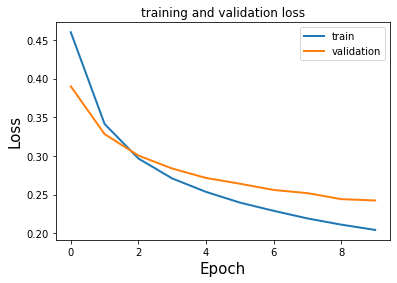

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

train_loss = np.load('../saved_models/task3/train_loss.npy')
val_loss = np.load('../saved_models/task3/val_loss.npy')
plt.plot(train_loss, linewidth=2, label='train')
plt.plot(val_loss, linewidth=2, label='validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.title('training and validation loss')

val accuracy: 0.48485172
train accuracy: 0.5448601


Text(0.5, 1.0, 'training and validation Accuracy')

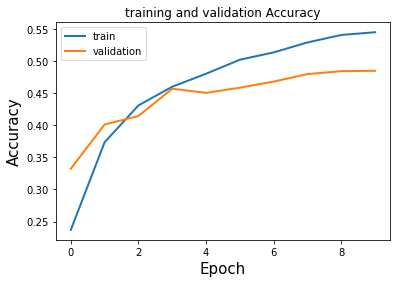

In [34]:
val_acc = np.load('../saved_models/task3/val_acc.npy')
train_acc = np.load('../saved_models/task3/train_acc.npy')
print('val accuracy:', val_acc[-1])
print('train accuracy:', train_acc[-1])
plt.plot(train_acc, linewidth=2, label='train')
plt.plot(val_acc, linewidth=2, label='validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.title('training and validation Accuracy')

labels shape (1876, 7)
pred shape (1876, 7)


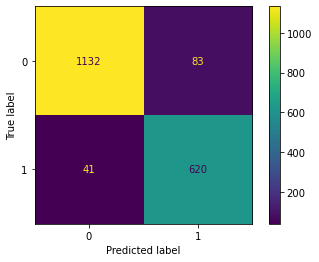

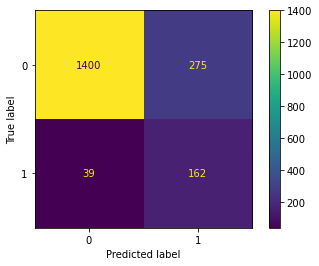

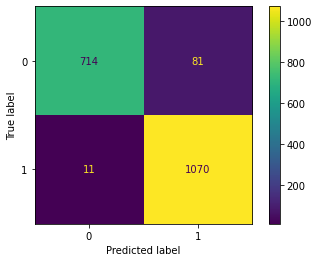

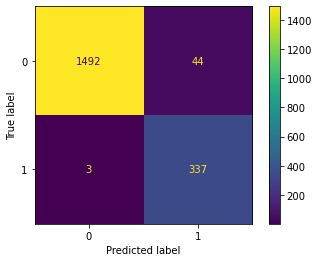

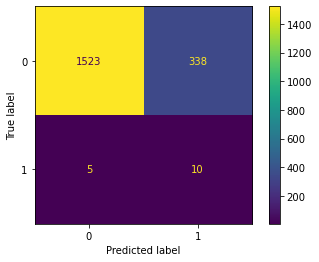

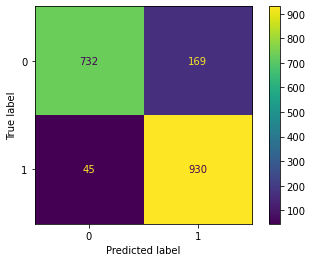

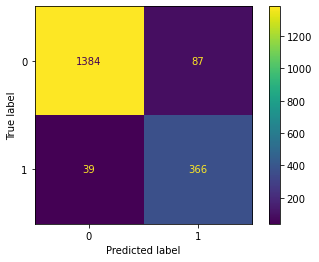

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
test_labels = np.array(test_labels)
test_pred = np.array(test_pred)
print('labels shape', test_labels.shape)
print('pred shape', test_pred.shape)
for i in range(7):
    cm = confusion_matrix(test_pred[:,i], test_labels[:,i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
plt.show()

In [35]:
def wrong_and_right(net, test_data_loader, device):
    net = net.to(device)
    test_steps = len(test_data_loader)
    t_acc=0
    wrong = 0 
    right = 0 
    for i, data in enumerate(test_data_loader): # iterate over batches
    # get image and labels data is in tuple form (inputs, label)
        image, labels = data
        image = image.to(device)
        labels = labels.to(device).float()
        net.eval()
        torch.no_grad()   
        outputs = net(image)
        pred = torch.tensor([[1 if i > 0.5 else 0 for i in y ] for y in outputs])
        t_acc = torch.sum((pred == labels).all(axis = 1))
        if t_acc <16 and t_acc>0:
            for i in range(0,16):
                if (pred[i] != labels[i]).any() and wrong == 0:
                    print('prediction: ', pred[i])
                    print('label: ', labels[i])
                    wrong = 1
                    plt.imshow(image[i].permute(1, 2, 0))
                    plt.show()
                if (pred[i] == labels[i]).all() and right == 0:
                    print('prediction: ', pred[i])
                    print('label: ', labels[i])
                    right = 1
                    plt.imshow(image[i].permute(1, 2, 0))
                    plt.show()
                if wrong ==1 and right==1:
                    return 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction:  tensor([0, 0, 1, 0, 0, 1, 0])
label:  tensor([0., 0., 1., 0., 0., 1., 0.])


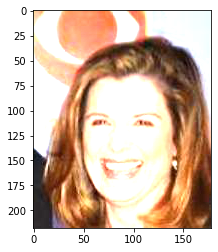

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction:  tensor([1, 0, 0, 1, 0, 1, 1])
label:  tensor([1., 0., 0., 1., 0., 0., 1.])


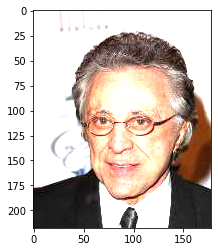

In [38]:
path = '../saved_models/task3/task3.pt'
net = Net().to(device)
net.load_state_dict(torch.load(path))
a = wrong_and_right(net,test_data_loader, device)